# Análise RFM

*O objetivo dessa análise é classificar e clusterizar os clientes de uma empresa utilizando a técnica de RFM - Recência, Frequência e Valor monetário*



1.   **Recência:** Última vez que uma ação foi realizada
2.   **Frequência:** Volume de ações realizadas
3.   **Valor monetário:** Valor que a ação resultou para o negócio, pode ser Receita ou Custo



### Prepação do ambiente

Para realizar a extração será necessário a instalaçao da biblioteca do kaggle para obtermos o dataset através de api.

Dataset: https://www.kaggle.com/datasets/carrie1/ecommerce-data

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"coelholindberg","key":"e8ee369dc6cc70552aaa785850b34d0b"}'}

In [4]:
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Instruções para configurar a biblioteca kaggle no Google Colab
https://www.kaggle.com/discussions/general/74235

Importando as bibliotecas necessárias

In [5]:
import kaggle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

### Extração do dados

###### Obtendo o dataset da plataforma Kaggle

In [6]:
!kaggle datasets download -d carrie1/ecommerce-data

  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 79.5MB/s]


In [7]:
z = ZipFile('ecommerce-data.zip', 'r')
z.extractall()
z.close()

###### Organizando as pastas no modelo de zonas do datalake

In [8]:
!mkdir datalake

In [9]:
!mkdir datalake/raw

In [10]:
!mkdir datalake/landing

In [11]:
!mkdir datalake/curated

In [12]:
!mv ecommerce-data.zip datalake/raw

In [13]:
!mv data.csv datalake/raw

In [41]:
df = pd.read_csv('datalake/raw/data.csv', encoding= 'unicode_escape')

###### Analisando o dataset

In [15]:
print('o dataset possui {} linhas e {} colunas'.format(df.shape[0], df.shape[1]))

o dataset possui 541909 linhas e 8 colunas


In [16]:
df.head(2).T

,0,1
InvoiceNo,536365,536365
StockCode,85123A,71053
Description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN
Quantity,6,6
InvoiceDate,12/1/2010 8:26,12/1/2010 8:26
UnitPrice,2.55,3.39
CustomerID,17850.0,17850.0
Country,United Kingdom,United Kingdom


### Transformação do dados

###### Explicando os campos



1. InvoiceNo: ID único para cada transação.
2. StockCode: ID único para cada produto
3. Description: Nome do produto
4. Quantity: Quantidade de cada item por transação
5. InvoiceDate: Data e hora que foi gerado a transação
6. UnitPrice: Preço unitário do produto
7. CustomerID: ID único para cada cliente
8. Country: Pais de residência do cliente

*O InvoiceNo que começa com a letra C indica que a transação foi cancelada*



###### Transformando os dados

Analisando os tipos de dados do dataset e o conteúdo

In [42]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [43]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [44]:
# Verificando se existem campos nulos
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [45]:
# Verificando os casos de transações canceladas
len(df[df['InvoiceNo'].str.contains('C',regex=False)])

9288

In [46]:
len(df[df['InvoiceNo'].str[0] == 'C'])

9288

In [47]:
# Elimando as transacoes canceladas
df_t = df.loc[df['InvoiceNo'].str[0] != 'C']

In [48]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    532621 non-null  object 
 1   StockCode    532621 non-null  object 
 2   Description  531167 non-null  object 
 3   Quantity     532621 non-null  int64  
 4   InvoiceDate  532621 non-null  object 
 5   UnitPrice    532621 non-null  float64
 6   CustomerID   397924 non-null  float64
 7   Country      532621 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.6+ MB


In [49]:
# Verificando se existem campos nulos
df_t.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64

In [50]:
# Analisando uma amostra com o feature CustomerID nula
df_t.loc[df_t['CustomerID'].isnull()].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom


In [51]:
# Considerando que ao vender um cliente pode não ser informado, será preenchido o campo com o valor 1,
# ao invés de apagarmos os registro
df_t.loc[df_t.CustomerID == 1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [52]:
# Tranformando a feature CustomerID de Float para Object
df_t['CustomerID'] = df_t['CustomerID'].fillna(1).astype(int).astype(str)

<ipython-input-52-7eeb36291cf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['CustomerID'] = df_t['CustomerID'].fillna(1).astype(int).astype(str)


In [53]:
# Analisando os registros que a descrição dos produtos estão nulas
df_t.loc[df_t['Description'].isnull()].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,1,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,1,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,1,United Kingdom


In [55]:
df_t.loc[df_t.StockCode == '22139']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
106,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,12/1/2010 9:41,4.25,15311,United Kingdom
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,1,United Kingdom
6392,536942,22139,amazon,15,12/3/2010 12:08,0.00,1,United Kingdom
6885,536982,22139,RETROSPOT TEA SET CERAMIC 11 PC,10,12/3/2010 14:27,11.02,1,United Kingdom
7203,537011,22139,NaN,-5,12/3/2010 15:38,0.00,1,United Kingdom
...,...,...,...,...,...,...,...,...
538411,581405,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,12/8/2011 13:50,4.95,13521,United Kingdom
539531,581439,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,12/8/2011 16:30,10.79,1,United Kingdom
540441,581486,22139,RETROSPOT TEA SET CERAMIC 11 PC,6,12/9/2011 9:38,4.95,17001,United Kingdom
541387,581498,22139,RETROSPOT TEA SET CERAMIC 11 PC,2,12/9/2011 10:26,10.79,1,United Kingdom


In [58]:
df_t = df_t.loc[df_t.UnitPrice > 0.0]

In [59]:
# Verificando se existem campos nulos
df_t.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [60]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530104 non-null  object 
 1   StockCode    530104 non-null  object 
 2   Description  530104 non-null  object 
 3   Quantity     530104 non-null  int64  
 4   InvoiceDate  530104 non-null  object 
 5   UnitPrice    530104 non-null  float64
 6   CustomerID   530104 non-null  object 
 7   Country      530104 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 36.4+ MB


In [61]:
df_t.loc[df_t.Quantity <= 0.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [64]:
# Transformando a feature InvoiceDate de Object para Date
df_t['InvoiceDate'] = pd.to_datetime(df_t['InvoiceDate'])

In [65]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   530104 non-null  object        
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.4+ MB


In [66]:
df_t.duplicated().sum()

5226

In [68]:
df_t.loc[df_t.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446,United Kingdom


In [69]:
df_t['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [70]:
df_t['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

###### Adicionando novas features

In [71]:
df_t['TotalPrice'] = df_t['UnitPrice'] * df_t['Quantity']

In [72]:
date_analysis = df_t['InvoiceDate'].max() + dt.timedelta(days=1)

###### Criando dataset para aplicar a classificação RFM

In [81]:
rfm = df_t.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (date_analysis - x.max()).days, 'InvoiceNo':'count','TotalPrice': 'sum'})


In [82]:
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
1,1,132220,1755276.64
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55


In [83]:
# Renomeando as colunas, pois elas são criadas com os nomes originais e não das métricas
rfm = rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'})

In [84]:
levels_rec =range(5,0,-1)
levels_freq=range(1,6)
levels_mon=range(1,6)

In [85]:
# Dividindo a lista de clientes em 5 quintis (dividindo nos quartis)
r_quintis = pd.qcut(rfm['Recency'], q=5, labels = levels_rec)
f_quintis = pd.qcut(rfm['Frequency'],q=5, labels = levels_freq)
m_quintis = pd.qcut(rfm['Monetary'],q=5,labels = levels_mon)
rfm = rfm.assign(R=r_quintis,F=f_quintis,M=m_quintis)

In [86]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
1,1,132220,1755276.64,5,5,5
12346,326,1,77183.60,1,1,5
12347,2,182,4310.00,5,5,5
12348,75,31,1797.24,2,3,4
12349,19,73,1757.55,4,4,4


In [87]:
# Criando tabela atribuindo níveis RFM e pontuação RFM (soma dos níveis)
def class_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])

In [89]:
rfm['RFM_cluster'] = rfm.apply(class_rfm,axis=1 )
rfm['RFM_score'] = rfm[['R','F','M']].sum(axis=1)
rfm['FM_media'] = rfm[['F','M']].mean(axis=1).round()
rfm = rfm.reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_cluster,RFM_score,FM_media
0,1,1,132220,1755276.64,5,5,5,555,15,5.0
1,12346,326,1,77183.60,1,1,5,115,7,3.0
2,12347,2,182,4310.00,5,5,5,555,15,5.0
3,12348,75,31,1797.24,2,3,4,234,9,4.0
4,12349,19,73,1757.55,4,4,4,444,12,4.0


In [90]:
matriz_rfm = rfm.pivot_table(values='CustomerID', index='FM_media', columns='R', aggfunc = 'count', fill_value=0)
matriz_rfm = matriz_rfm.loc[[5.0, 4.0, 3.0, 2.0, 1.0],[1, 2, 3, 4, 5]]
matriz_rfm

R,1,2,3,4,5
FM_media,,,,,
5.0,8,35,82,169,307
4.0,75,216,281,344,334
3.0,86,152,129,117,87
2.0,424,317,276,203,106
1.0,272,123,90,71,35


### Apresentando uma matriz comparativa entre a pontuação e o volume de cliente em cada classificação

###### Plotando o resultado em uma matriz de confusão

Text(0.5, 1.0, 'Matriz RFM')

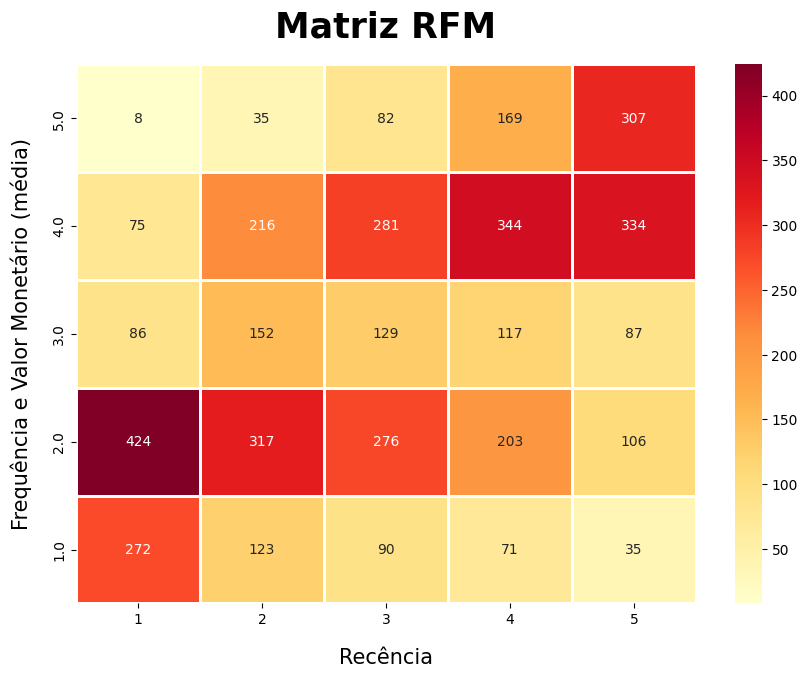

In [92]:
plt.figure(figsize=(10,7))
plot = sns.heatmap(matriz_rfm,cmap='YlOrRd',linewidth=1, linecolor="white", annot=True, fmt ='.0f')
plot.set_xlabel('Recência', fontsize=15, labelpad=15)
plot.set_ylabel('Frequência e Valor Monetário (média)', fontsize=15, labelpad=15)
plot.set_title('Matriz RFM', fontsize=25, fontweight="bold", pad=20)

In [93]:
# Clientes campeões
rfm.loc[rfm['RFM_cluster']=='555']

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_cluster,RFM_score,FM_media
0,1,1,132220,1755276.64,5,5,5,555,15,5.0
2,12347,2,182,4310.00,5,5,5,555,15,5.0
16,12362,3,266,5226.23,5,5,5,555,15,5.0
57,12417,3,192,3649.10,5,5,5,555,15,5.0
72,12433,1,420,13375.87,5,5,5,555,15,5.0
...,...,...,...,...,...,...,...,...,...,...
4294,18225,3,271,5509.12,5,5,5,555,15,5.0
4298,18229,12,164,7276.90,5,5,5,555,15,5.0
4310,18245,7,175,2567.06,5,5,5,555,15,5.0
4328,18272,3,166,3078.58,5,5,5,555,15,5.0


###### Classificando os clientes

In [94]:
rfm['R'] = rfm['R'].astype('int64')
rfm['FM_media'] = rfm['FM_media'].astype('int64')

In [95]:
def classification(df):
    if (df['FM_media'] == 5) and (df['R'] == 1):
        return 'Não posso perdê-lo'
    elif (df['FM_media'] == 5) and ((df['R'] == 3) or (df['R'] == 4)):
        return 'Cliente leal'
    elif (df['FM_media'] == 5) and (df['R'] == 5):
        return 'Campeão'
    elif (df['FM_media'] == 4) and (df['R'] >= 3):
        return 'Cliente leal'
    elif (df['FM_media'] == 3) and (df['R'] == 3):
        return 'Precisa de atenção'
    elif ((df['FM_media'] == 3) or (df['FM_media'] == 2))  and (df['R'] > 3):
        return 'Lealdade potencial'
    elif ((df['FM_media'] == 2) or (df['FM_media'] == 1)) and (df['R'] == 1):
        return 'Perdido'
    elif (df['FM_media'] == 2) and (df['R'] == 2):
        return 'Hibernando'
    elif ((df['FM_media'] == 2) or (df['R'] == 1)) and (df['R'] == 3):
        return 'Prestes a hibernar'
    elif (df['FM_media'] == 1) and (df['R'] == 2):
        return 'Perdido'
    elif (df['FM_media'] == 1) and (df['R'] == 4):
        return 'Promissor'
    elif (df['FM_media'] == 1) and (df['R'] == 5):
        return 'Recentes'
    else:
        return 'Em risco'

In [96]:
rfm['classification'] = rfm.apply(classification,axis=1)

In [97]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_cluster,RFM_score,FM_media,classification
0,1,1,132220,1755276.64,5,5,5,555,15,5,Campeão
1,12346,326,1,77183.60,1,1,5,115,7,3,Em risco
2,12347,2,182,4310.00,5,5,5,555,15,5,Campeão
3,12348,75,31,1797.24,2,3,4,234,9,4,Em risco
4,12349,19,73,1757.55,4,4,4,444,12,4,Cliente leal


###### Salvando as bases geradas

In [99]:
df_t.to_csv('datalake/landing/data_transformation.csv', encoding='utf8', sep=';')

In [100]:
rfm.to_csv('datalake/curated/data_rfm.csv', encoding='utf8', sep=';')